In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.semi_supervised import SelfTrainingClassifier


In [2]:
# Carregando o conjunto de dados
dados = pd.read_csv('qualidade_leite.csv')

# Exibindo informações gerais sobre o dataset
print(dados.info())  # Informações sobre colunas, tipos de dados e valores não nulos
print(dados.describe())  # Estatísticas descritivas para variáveis numéricas
print(dados['Qualidade'].value_counts(dropna=False))  # Contagem das classes na variável alvo


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pH           1059 non-null   float64
 1   Temperatura  1059 non-null   int64  
 2   Sabor        1059 non-null   int64  
 3   Odor         1059 non-null   int64  
 4   Gordura      1059 non-null   int64  
 5   Turbidez     1059 non-null   int64  
 6   Cor          1059 non-null   int64  
 7   Qualidade    424 non-null    object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB
None
                pH  Temperatura        Sabor         Odor      Gordura  \
count  1059.000000  1059.000000  1059.000000  1059.000000  1059.000000   
mean      6.630123    44.226629     0.546742     0.432483     0.671388   
std       1.399679    10.098364     0.498046     0.495655     0.469930   
min       3.000000    34.000000     0.000000     0.000000     0.000000   
25%       6.500000    38.000000     

In [3]:
# Removendo linhas com valores ausentes na coluna 'Qualidade'
dados_rotulados = dados.dropna()

# Separando as variáveis independentes (features) e a variável dependente (target)
x = dados_rotulados.drop('Qualidade', axis=1)  # Variáveis independentes
y = dados_rotulados['Qualidade']  # Variável dependente


In [4]:
# Codificando a variável 'Qualidade' em formato numérico
label_encoder = LabelEncoder()  # Inicializando o codificador
y = label_encoder.fit_transform(y)  # Transformando a variável alvo em números


In [5]:
# Normalizando os dados das variáveis independentes
scaler = MinMaxScaler()  # Inicializando o escalador
x_normalizado = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)  # Aplicando a normalização


In [6]:
# Dividindo os dados em conjuntos de treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x_normalizado, y, stratify=y, random_state=10)

# Stratify garante que a proporção das classes na variável alvo seja mantida


In [7]:
# Treinando o modelo SVM com um kernel linear
svm = SVC(kernel='linear', random_state=10)  # Inicializando o modelo SVM
svm.fit(x_treino, y_treino)  # Ajustando o modelo aos dados de treino


SVC(kernel='linear', random_state=10)

In [8]:
# Avaliando o desempenho do modelo
y_previsto = svm.predict(x_teste)  # Realizando previsões no conjunto de teste
resultados_svm = classification_report(y_teste, y_previsto)  # Gerando relatório de classificação
print('Resultados SVM Supervisionado:')
print(resultados_svm)  # Exibindo os resultados


Resultados SVM Supervisionado:
              precision    recall  f1-score   support

           0       0.75      0.39      0.51        23
           1       0.67      0.91      0.77        46
           2       0.90      0.76      0.82        37

    accuracy                           0.75       106
   macro avg       0.77      0.69      0.70       106
weighted avg       0.77      0.75      0.73       106



In [9]:
# Identificando dados sem rótulo (valores ausentes na coluna 'Qualidade')
dados_sem_rotulo = dados[dados['Qualidade'].isna()].drop('Qualidade', axis=1)  # Selecionando dados sem rótulo
dados_sem_rotulo_normalizados = pd.DataFrame(scaler.transform(dados_sem_rotulo), columns=dados_sem_rotulo.columns)  # Normalizando os dados sem rótulo


In [10]:
# Realizando previsões para os dados sem rótulo
y_previsto = svm.predict(dados_sem_rotulo_normalizados)  # Previsões para dados não rotulados


In [11]:
# Criando um novo conjunto de treino com dados rotulados e não rotulados
novo_x_treino = pd.concat([x_treino, dados_sem_rotulo_normalizados], ignore_index=True)  # Concatenando os dados de treino
novo_y_treino = pd.concat([pd.Series(y_treino), pd.Series(y_previsto)], ignore_index=True)  # Concatenando os rótulos


In [12]:
# Treinando SVM com pseudo rotulação usando os novos dados
pseudo_labeling = SVC(kernel='linear', random_state=10)  # Inicializando o modelo SVM para pseudo rotulação
pseudo_labeling.fit(novo_x_treino, novo_y_treino)  # Ajustando o modelo com os novos dados
novo_y_previsto = pseudo_labeling.predict(x_teste)  # Realizando previsões no conjunto de teste


In [13]:
# Avaliando o modelo com pseudo rotulação
resultados_pseudo_labeling = classification_report(y_teste, novo_y_previsto)  # Gerando relatório de classificação
print('Resultados SVM Pseudo Labeling:')
print(resultados_pseudo_labeling)  # Exibindo os resultados


Resultados SVM Pseudo Labeling:
              precision    recall  f1-score   support

           0       0.69      0.39      0.50        23
           1       0.66      0.87      0.75        46
           2       0.88      0.76      0.81        37

    accuracy                           0.73       106
   macro avg       0.74      0.67      0.69       106
weighted avg       0.74      0.73      0.72       106



In [14]:
# Re-treinando o modelo com probabilidade
x_treino, x_teste, y_treino, y_teste = train_test_split(x_normalizado, y, stratify=y, random_state=10)  # Novamente dividindo os dados
svm = SVC(kernel='linear', probability=True, random_state=10)  # Habilitando probabilidades no modelo SVM
svm.fit(x_treino, y_treino)  # Ajustando o modelo aos dados de treino


SVC(kernel='linear', probability=True, random_state=10)

In [15]:
# Obtendo probabilidades para dados sem rótulo
probabilidades = svm.predict_proba(dados_sem_rotulo_normalizados)  # Previsões de probabilidade para dados não rotulados
y_previsto = svm.predict(dados_sem_rotulo_normalizados)  # Previsões para dados não rotulados


In [16]:
# Criando uma tabela com os resultados das previsões
tabela_resultados = pd.DataFrame(probabilidades, columns=['Prob C0', 'Prob C1', 'Prob C2'])  # Criando DataFrame com probabilidades
tabela_resultados['Previsão'] = y_previsto  # Adicionando as previsões à tabela
tabela_resultados['Probabilidade máxima'] = tabela_resultados[['Prob C0', 'Prob C1', 'Prob C2']].max(axis=1)  # Calculando a probabilidade máxima


<Axes: ylabel='Frequency'>

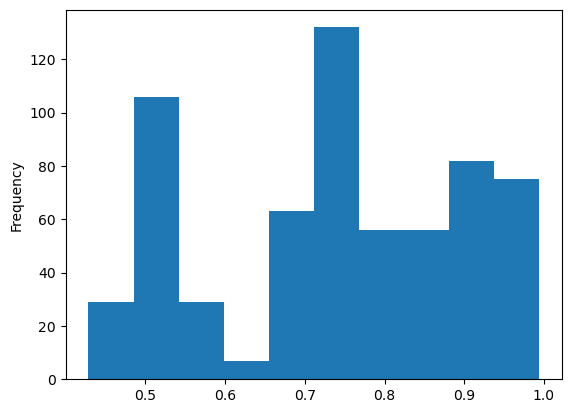

In [17]:
# Visualizando a distribuição das probabilidades
tabela_resultados['Probabilidade máxima'].plot(kind='hist')  # Criando um histograma das probabilidades máximas


In [18]:
# Filtrando previsões com alta confiança (probabilidade > 0.75)
filtro_confianca = tabela_resultados['Probabilidade máxima'] > 0.75  # Definindo um filtro para alta confiança
novo_x_treino = pd.concat([x_treino, dados_sem_rotulo_normalizados[filtro_confianca]])  # Concatenando dados de alta confiança
novo_y_treino = pd.concat([pd.Series(y_treino), tabela_resultados.loc[filtro_confianca, 'Previsão']])  # Concatenando rótulos de alta confiança


In [19]:
# Treinando novamente o modelo SVM com dados de alta confiança
svm = SVC(kernel='linear', probability=True, random_state=10)  # Inicializando o modelo SVM
svm.fit(novo_x_treino, novo_y_treino)  # Ajustando o modelo aos novos dados
novo_y_previsto = svm.predict(x_teste)  # Realizando previsões no conjunto de teste


In [20]:
# Avaliando o modelo final
resultados_self_training1 = classification_report(y_teste, novo_y_previsto)  # Gerando relatório de classificação
print('Resultados SVM Self Training 1º Estágio:')
print(resultados_self_training1)  # Exibindo os resultados


Resultados SVM Self Training 1º Estágio:
              precision    recall  f1-score   support

           0       0.75      0.39      0.51        23
           1       0.72      0.91      0.81        46
           2       0.92      0.89      0.90        37

    accuracy                           0.79       106
   macro avg       0.80      0.73      0.74       106
weighted avg       0.80      0.79      0.78       106



In [21]:
# Implementando o Self Training
x_treino_self_training = pd.concat([x_treino, dados_sem_rotulo_normalizados], ignore_index=True)  # Concatenando dados para treinamento
y_treino_self_training = pd.concat([pd.Series(y_treino), pd.Series([-1] * dados_sem_rotulo_normalizados.shape[0])], ignore_index=True)  # Criando rótulos para dados não rotulados


In [22]:
# Treinando o modelo Self Training
svm = SVC(kernel='linear', probability=True, random_state=10)  # Inicializando o modelo SVM
self_training = SelfTrainingClassifier(svm, threshold=0.80, max_iter=15, verbose=True)  # Criando o classificador de auto-treinamento
self_training.fit(x_treino_self_training, y_treino_self_training)  # Ajustando o modelo
y_previsto = self_training.predict(x_teste)  # Realizando previsões no conjunto de teste


End of iteration 1, added 244 new labels.
End of iteration 2, added 105 new labels.
End of iteration 3, added 50 new labels.
End of iteration 4, added 3 new labels.
End of iteration 5, added 14 new labels.


In [23]:
# Avaliando o modelo Self Training
resultados_self_training = classification_report(y_teste, y_previsto)  # Gerando relatório de classificação
print('Resultados SVM Self Training:')
print(resultados_self_training)  # Exibindo os resultados


Resultados SVM Self Training:
              precision    recall  f1-score   support

           0       0.83      0.65      0.73        23
           1       0.81      0.91      0.86        46
           2       0.92      0.89      0.90        37

    accuracy                           0.85       106
   macro avg       0.85      0.82      0.83       106
weighted avg       0.85      0.85      0.85       106

